In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scipy.ndimage as ndi
from skimage import transform, io, measure, color,morphology
import os
import cal_TDR_FDR
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [2]:
def normalize(im):
    '''
    标准化 到0 255
    对比度拉伸
    '''
    im = im.astype(np.float)
    min_ = np.min(im)
    im = im - min_
    
    min_ = 0
    max_ = np.max(im)
    im= im/max_ *255
    return im.astype(np.uint8)

def binarize_otsu(im):
    threshold, img_res = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return threshold, img_res

def plot_gray_img(im,title):
    plt.title(title)
    plt.imshow(im,cmap='gray'), plt.axis('off')
    plt.show()

def plot_im_gray_hist(im,title):
    plt.title(title)
    plt.hist(im.ravel(), 256, [0, 256])
    plt.show()

def gray_to_rgb(im_gray):
    h,w = im_gray.shape
    im_rgb = np.zeros((h,w,3),np.uint8)
    im_rgb[:,:,0] = im_gray.copy()
    im_rgb[:,:,1] = im_gray.copy()
    im_rgb[:,:,2] = im_gray.copy()
    return im_rgb
    
def show_predict(im_gray,predict):
    im_rgb = gray_to_rgb(im_gray)
    for p in predict:
        cv2.circle(im_rgb,p,2,(0,255,0)) # 2 直径 (0,255,0) 颜色     
#     plt.title(title)
#     plt.imshow(im_rgb), plt.axis('off')
#     plt.show()
    return im_rgb
    

def show_predict_and_gt(im_gray, predict, gt, title):
    im_rgb = gray_to_rgb(im_gray)
    im_rgb_pred = im_rgb.copy()
    im_rgb_gt = im_rgb.copy()

    for p in predict:
        cv2.circle(im_rgb_pred,p,2,(0,255,0)) # 2 直径 (0,255,0) 颜色
        
    for p in gt:
        cv2.circle(im_rgb_gt,p,2,(0,255,0)) # 2 直径 (0,255,0) 颜色
    
    plt.figure(figsize=(20, 10 ))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.title('predict')
    plt.imshow(im_rgb_pred), plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('gt')
    plt.imshow(im_rgb_gt), plt.axis('off')
    plt.show() 


In [3]:
def scale_filtr(groups):
    new_res = []
    remove_res = []
    for reg in groups:
        if reg.area <= 80 and reg.area >=2:
            new_res.append(reg)
        else:
            remove_res .append(reg)
    return new_res, remove_res

def get_group_center(groups):
    # (行号, 列号)
    return [(int(g.centroid[1]),int(g.centroid[0])) for g in groups]

def get_ridge(img_norm):
    threshold, bina = cv2.threshold(img_norm,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    labels = measure.label(bina,connectivity=2)
#     plot_gray_img(bina,'bin')
#     print(labels.max())
    count_dst = [(i, np.sum(labels==i))   for i in range(labels.max()+1)]
    count_dst.sort(key= lambda x:x[1] , reverse=True)
    num_threshold = 100 # 多于60个点的为背景
    # 0为 指纹背景
    count_dst = [ i for i in count_dst if i[1]>=num_threshold]
    l_dst = [i[0] for i in count_dst]
#     print(count_dst)

    # 点 
    cannn = np.ones(img_norm.shape, dtype=np.uint8)
    for i in range(bina.shape[0]):
        for j in range(bina.shape[1]):
            if labels[i][j] in l_dst:
                cannn[i,j]=0
#     plot_gray_img(cannn,'ridge')
    return cannn


def eccentricity_filter(im_norm,group_att):
    # 离心率阈值
    ecc_threshold = 0.999999
    res = []
    rm = []
    ca = np.zeros(im_norm.shape,dtype=np.uint8)
    for i in group_att:
        if i.eccentricity <= ecc_threshold:            # 画出来
            res.append(i)
        else:
            rm.append(i)
#             for coo in i.coords:
#                 ca[coo[0],coo[1]] = 255
#     plt.imshow(ca,cmap='gray'), plt.axis('off')
#     plt.show()
    return res,rm

def light_filter(im_norm,th,group_att):
    counts = [ (i,np.sum(im_norm==i))   for i in range(int(th)+1)]
    # print(counts)
    counts.sort(key=lambda x:x[1],reverse=True)
    # print(counts)
    dark_threshold = counts[0][0]
    res = []
    rm = []
    for group in group_att:
        bbox_r1, bbox_c1, bbox_r2, bbox_c2 = group.bbox
 
        mask = group.convex_image.astype(np.uint8)
        pore_gray = np.sum(im_norm[bbox_r1:bbox_r2,bbox_c1:bbox_c2] * mask)/ float(group.area)

        if(pore_gray >  dark_threshold  ):
            res.append(group)
        else:
            rm.append(group)
    return res,rm

def contrast_filter(im_norm,group_att):
    res = []
    rm = []
    for group in group_att:
        bbox_r1, bbox_c1, bbox_r2, bbox_c2 = group.bbox
 
        mask = group.convex_image.astype(np.uint8)
        bbox = im_norm[bbox_r1:bbox_r2,bbox_c1:bbox_c2]
        pore_gray = np.sum(bbox * mask)/ float(group.area)
        
        height, width = bbox.shape#todo 方向对比度
        height = int(height /2)
        width = int(width /2)
        img_height, img_width = im_norm.shape
        new_area_r1 = max(0, bbox_r1 - height)
        new_area_r2 = bbox_r2 + height
        new_area_c1 = max(0, bbox_c1 - width)
        new_area_c2 = bbox_c2 + width
        

        large_mask = np.ones(im_norm.shape,np.uint8)
        negative_mask = mask.copy()
        negative_mask[mask==1]=0
        negative_mask[mask==0]=1
        large_box = im_norm[new_area_r1:new_area_r2,new_area_c1:new_area_c2]
        large_mask[bbox_r1:bbox_r2,bbox_c1:bbox_c2] = negative_mask
        
        large_area = im_norm[new_area_r1:new_area_r2,new_area_c1:new_area_c2]
        large_mask_local = large_mask[new_area_r1:new_area_r2,new_area_c1:new_area_c2]
        outer_gray_sum = np.sum( large_area * large_mask_local)/ float(large_area.shape[0]*large_area.shape[1]-group.area)
    

        contract =   pore_gray /outer_gray_sum
#         print('pore',pore_gray)
#         print('t',outer_gray_sum)
#         print('conr',contract)
        if(contract >=1.2):
            res.append(group)
        else:
            rm.append(group)
    return res, rm

def dog(img_filename):
    img_basename = os.path.basename(img_filename)
    
    # 1 
    # imread 得到灰度图, 
    im = cv2.imread(img_filename, cv2.IMREAD_GRAYSCALE)

    
    # 2
    # norm 归一化 对比度拉伸
    im_norm = normalize(im)
    th_borm, im_bina = binarize_otsu(im_norm)
    im_norm_float = im_norm.astype(np.float)
    
    # 3
    # DoG
    im_gaus1 = cv2.GaussianBlur(im_norm_float,(3,3),1)
    im_gaus2 = cv2.GaussianBlur(im_norm_float,(5,5),7) # float

    im_dog = im_gaus1 - im_gaus2
    
    im_dog[im_dog<0] = 0
    im_dog[im_dog>255]=255
#     im_dog = normalize(im_dog)
    im_dog = im_dog.astype(np.uint8)

    im_dog_norm = normalize(im_dog)
    im_dog_threshold, im_dog_bin = binarize_otsu(im_dog_norm)
    #         print('pore',pore_gray)
#     plot_gray_img(im_dog_bin,'im_dog_bin')

    
    #### 去伪汗孔
    # 4
    # 去脊
    # 获取脊
    # 先均值滤波
    # 均值与 形态学同时使用
#     im_norm_mean = cv2.blur(im,(3,3))
    im_norm_mean = cv2.GaussianBlur(im,(3,3),2)
    im_norm_mean_threshold, im_norm_mean_bin = binarize_otsu(im_norm_mean)
    im_norm_mean_bin[im_bina==0]=0
#     plot_gray_img(im_norm_mean_bin,'im_gaus')
    im_bool=im_norm_mean_bin.astype(bool)  
    im_mean_remove_close=morphology.remove_small_objects(im_bool,min_size=40,connectivity=2).astype(np.uint8) #联通区域小于40的视为闭汗孔，移除
#     plot_gray_img(im_mean_remove_close,'im_mean_remove_close')

    im_remove_ridge = im_dog_bin.copy()

    im_remove_ridge[im_mean_remove_close==1]=0
#     plot_gray_img(im_remove_ridge,'im_remove_ridge')

    
    # 连通分支
    group_labels = measure.label(im_remove_ridge,connectivity=2)
    group_att = measure.regionprops(group_labels) 
    
    # 尺寸筛选
    group_att, remove_res = scale_filtr(group_att)
    
#     # 离心率
#     group_att, remove_res = eccentricity_filter(im_norm,group_att)

#     # 亮度筛选
#     group_att,remove_res= light_filter(im_norm,th_borm, group_att)

#     # 对比度
    group_att,remove_res = contrast_filter(im_norm, group_att)

    predicts = get_group_center(group_att)

    with open('location/'+ img_basename.split('.')[0] +'.txt') as f:
        lines = f.readlines()
        lines = [ line.strip().split()  for line in lines]
        lines = [ (int(line[1]),int(line[0]))  for line in lines]
    show_predict_and_gt(im_norm,predicts,lines,img_basename)
    result_imgs = show_predict(im_norm,predicts)
    return predicts, result_imgs

def main():
    im_paths = [  'task1img/' + str(i)+'.jpg' for i in range(1,16)] # 这里是im的路径
    
    test_path = ['1.jpg','11.jpg','5.jpg','12.jpg','15.jpg','14.jpg']
#     im_paths = test_path
    results = [ dog(im) for im in im_paths ]
    
    for index,res in enumerate(results):
        with open('res_txt/' +str(index+1)+'.txt','w') as f:
            for row,column in res[0]:
                f.write('{} {}\n'.format(column,row))
            cv2.imwrite('res_img/' +str(index+1)+'.png',res[1])
    
    f_score, tdr, fdr = cal_TDR_FDR.cal('location','res_txt')
    print('TDR = {}'.format(tdr))
    print('FDR = {}'.format(fdr))
    print('F-score = {}'.format(f_score))


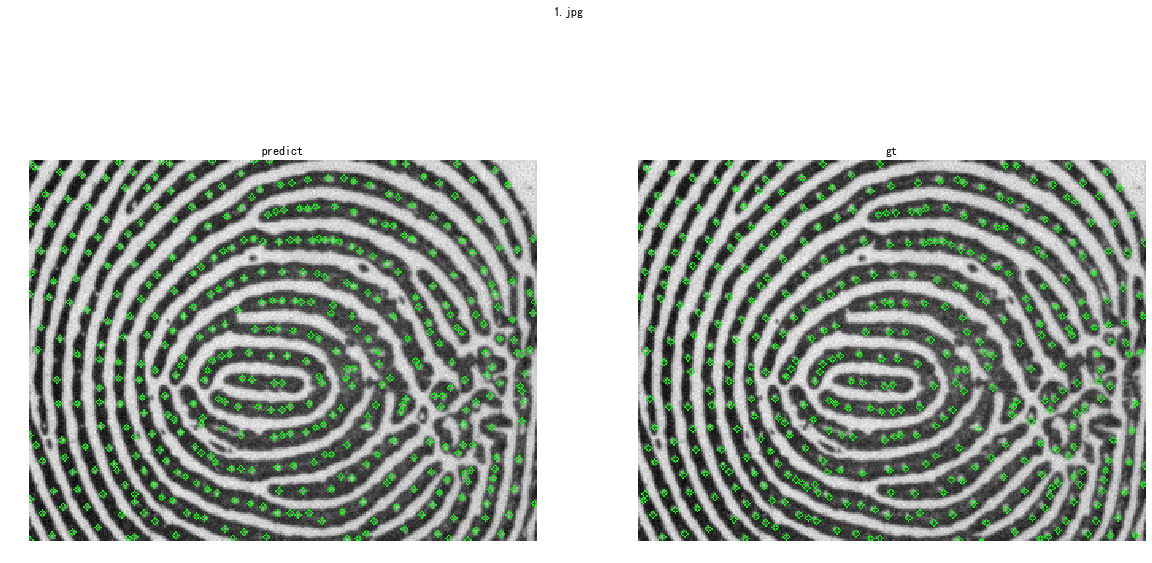

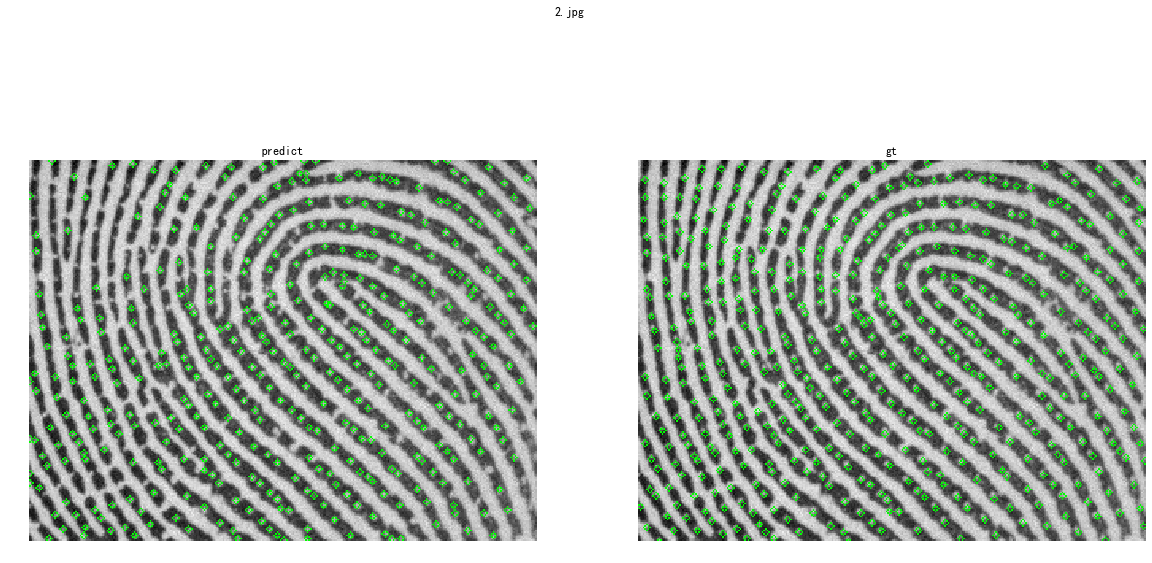

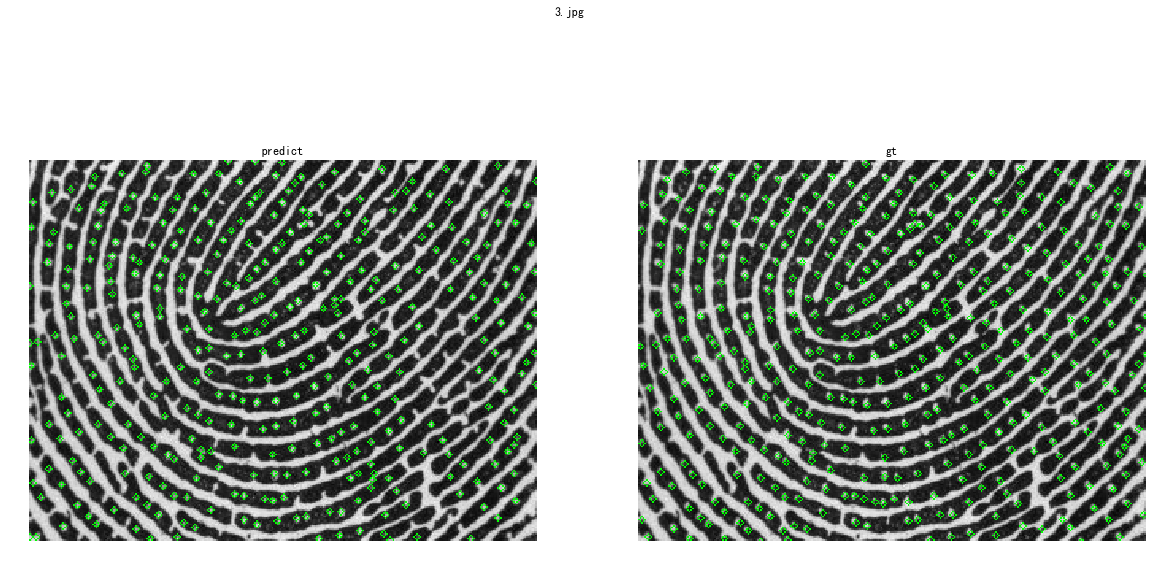

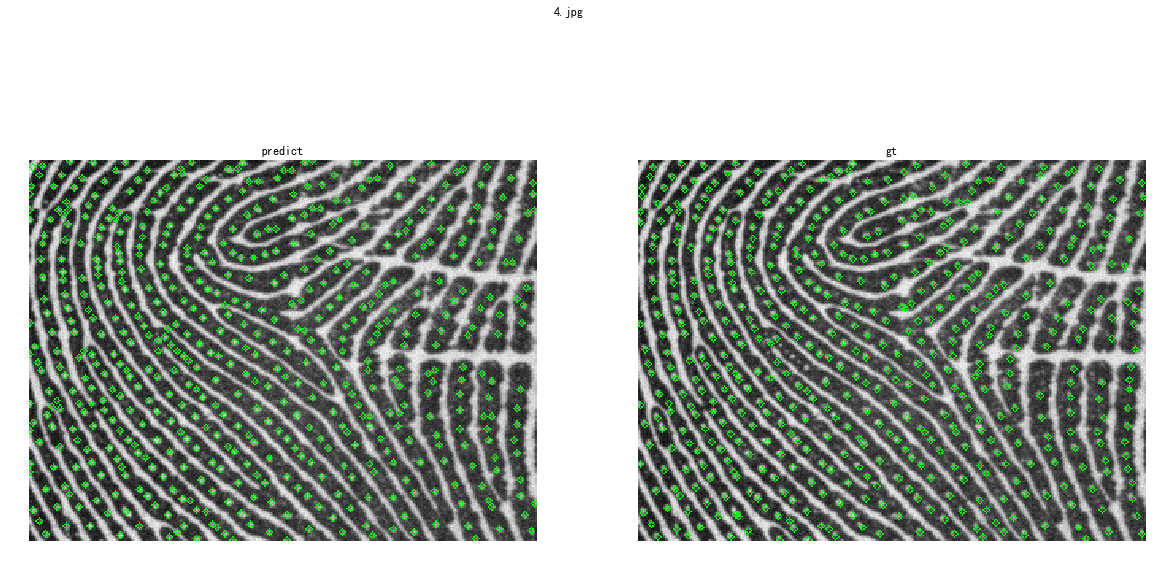

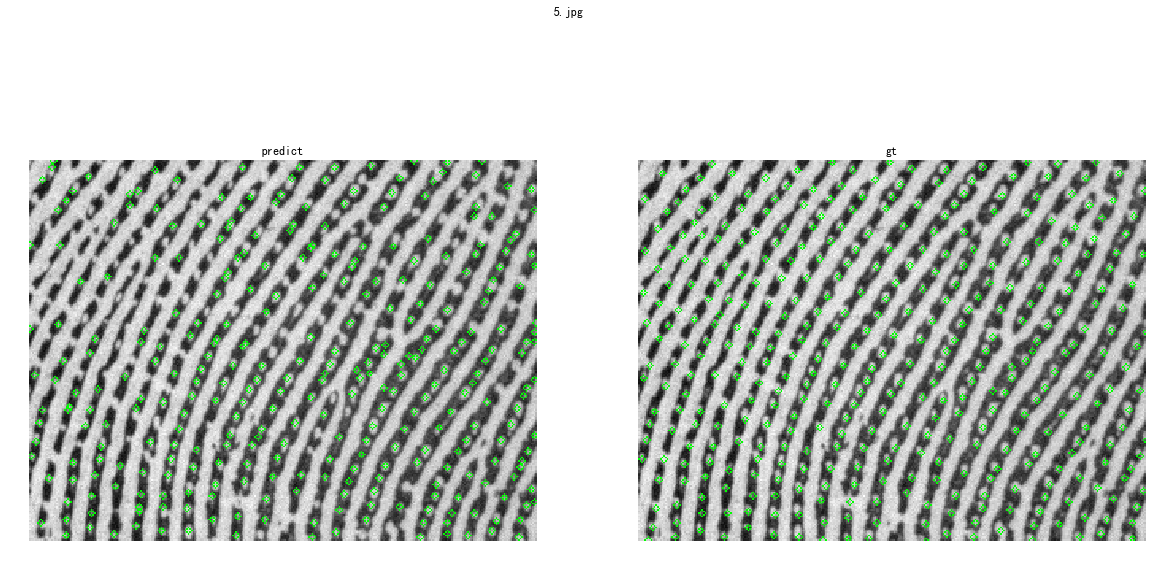

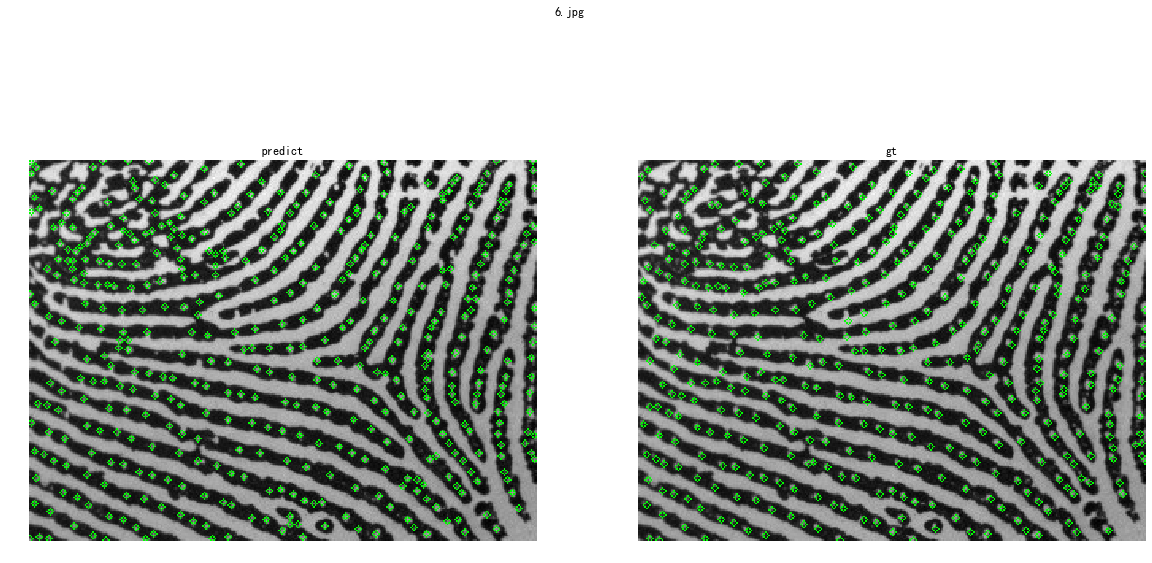

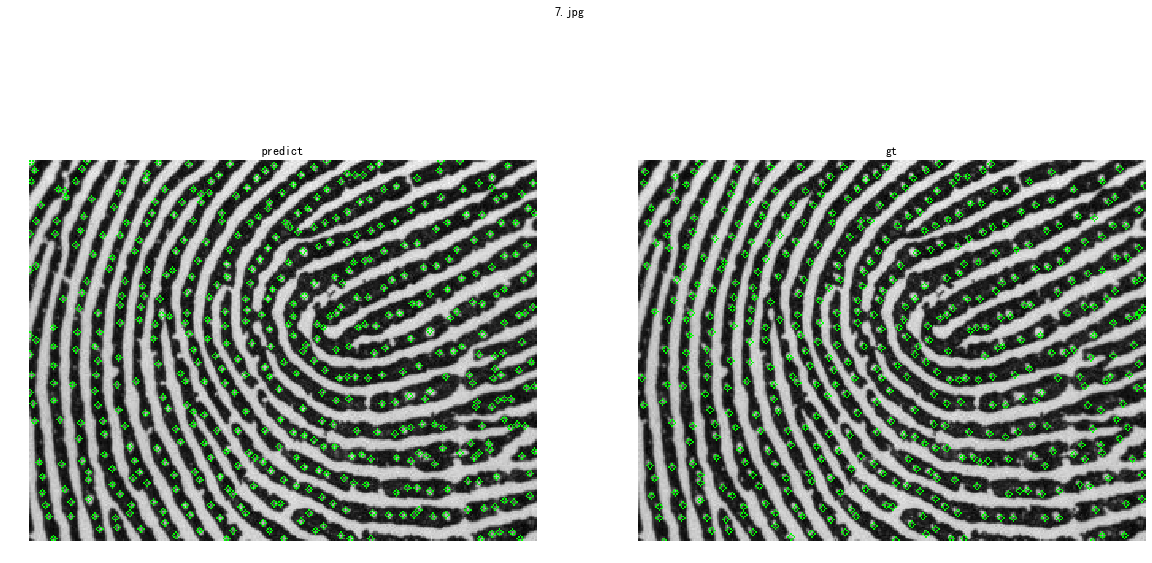

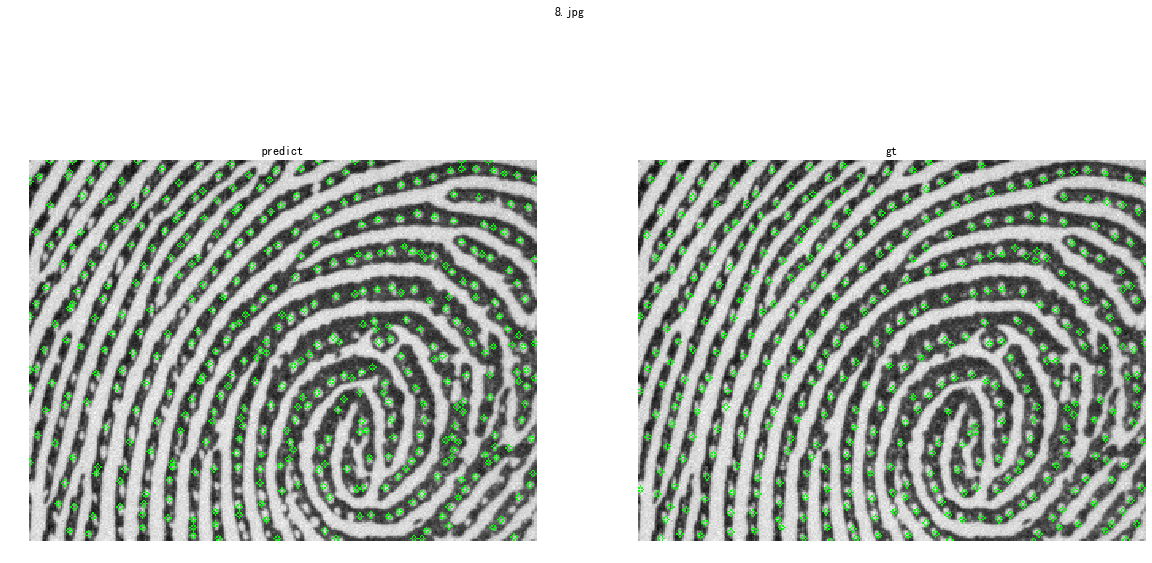

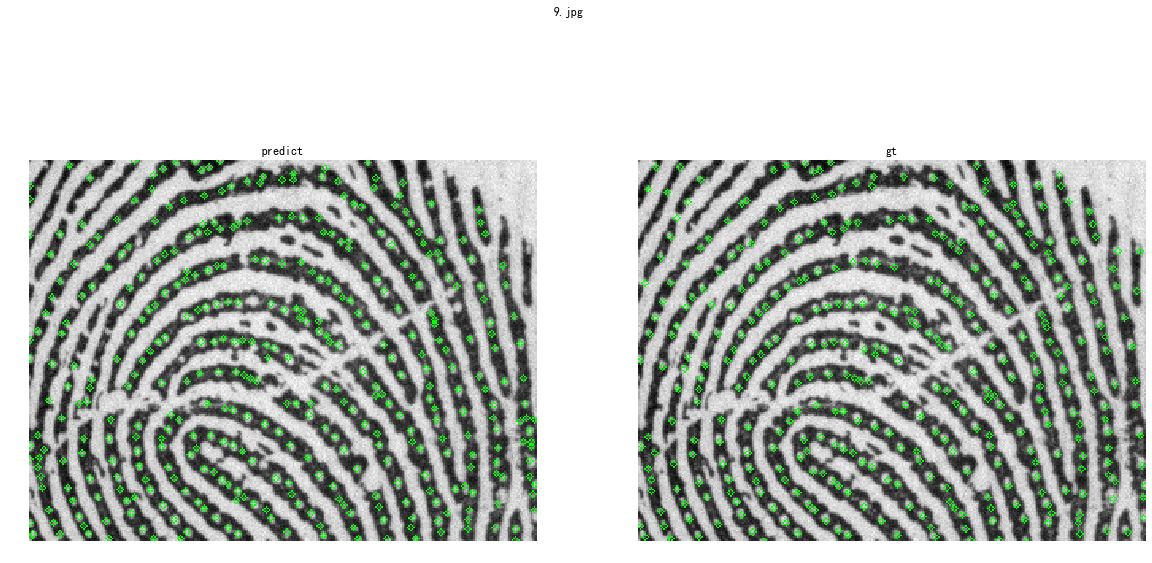

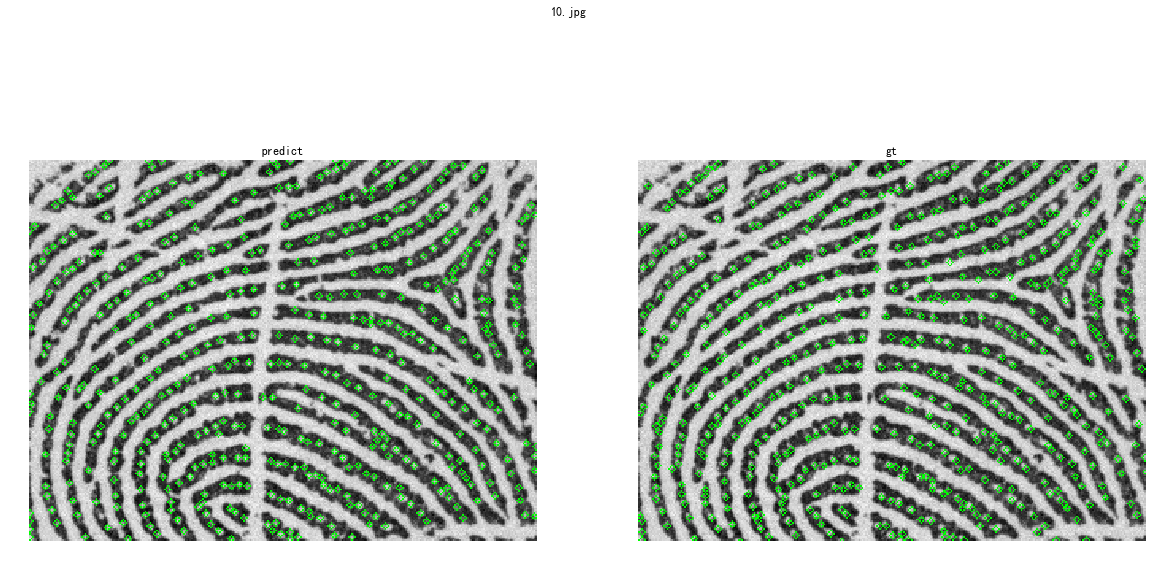

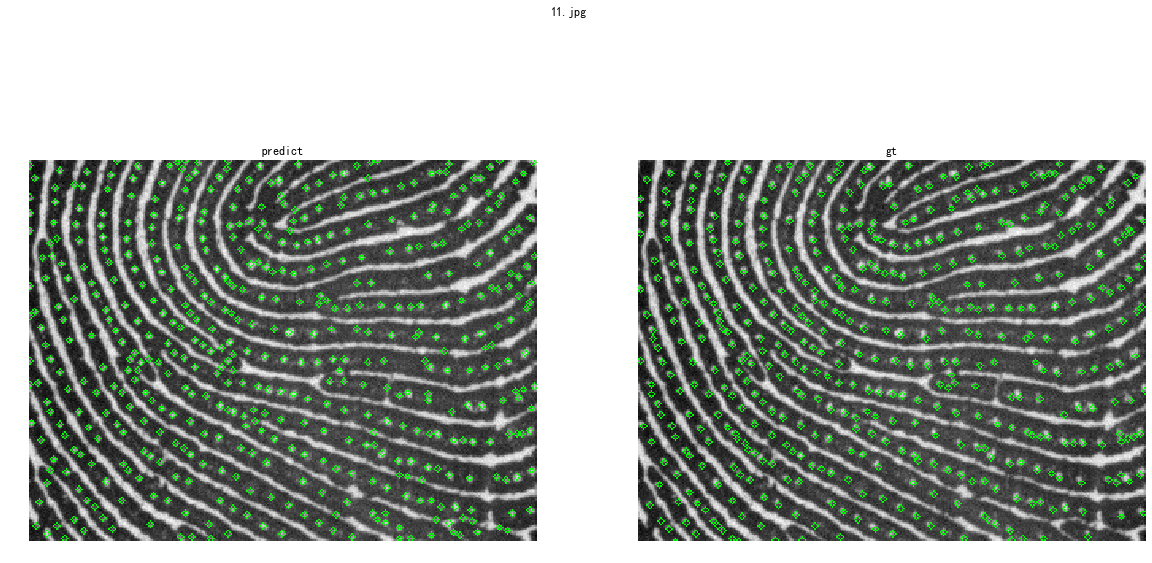

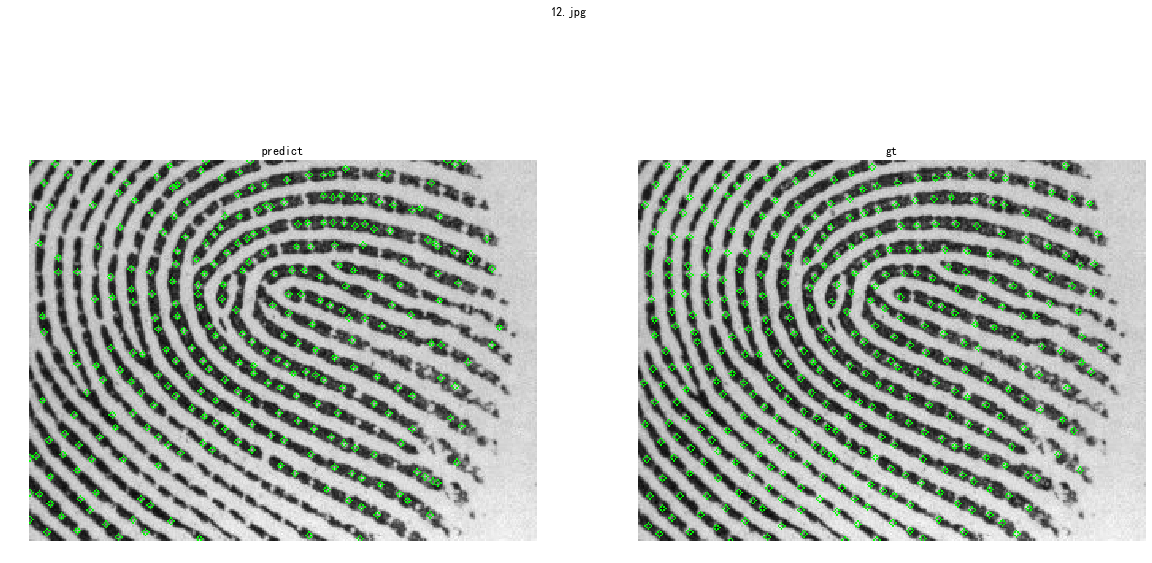

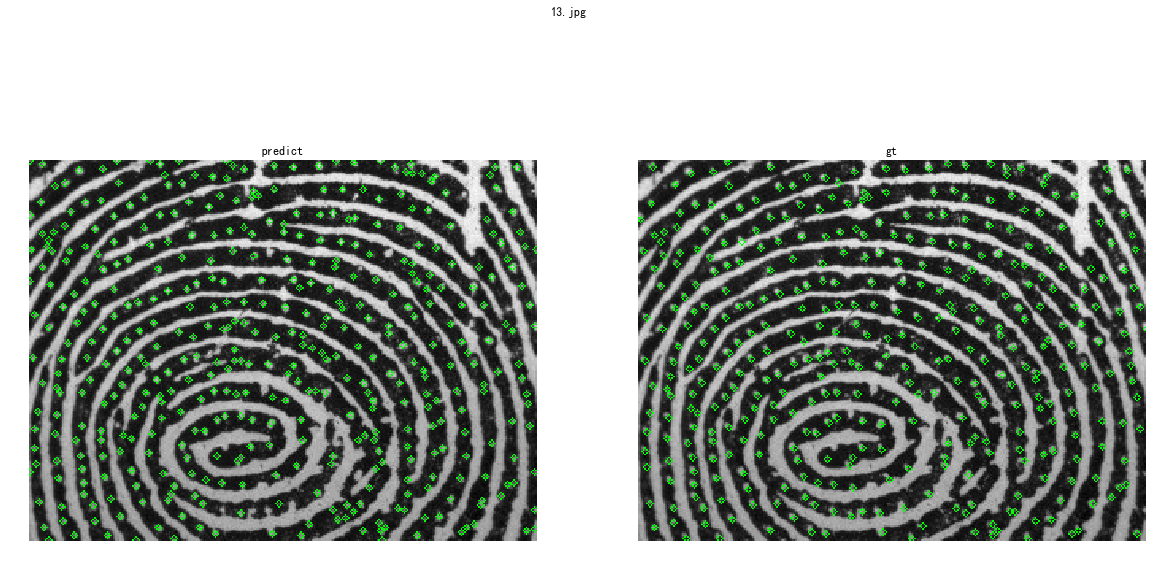

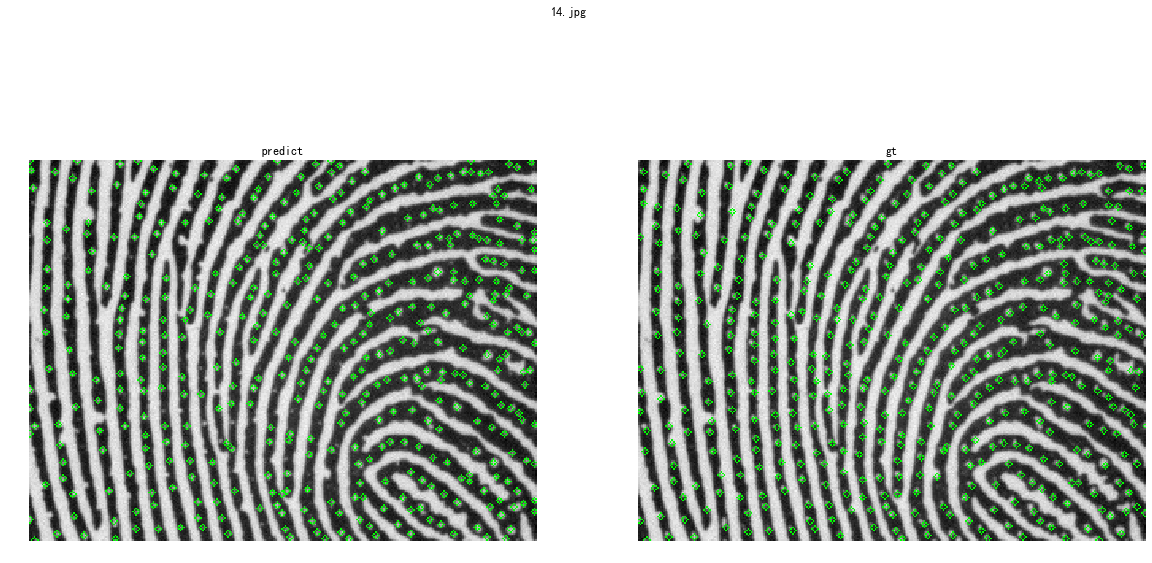

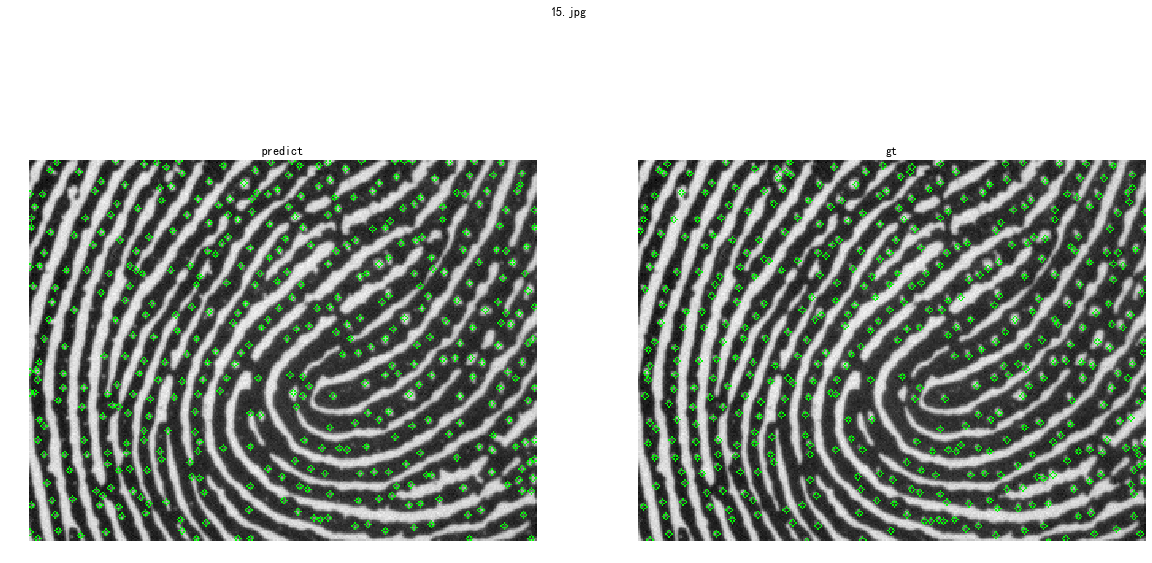

TDR = 0.8520988015576622
FDR = 0.1197557919227367
F-score = 0.8659428653668032


In [4]:
main()
# main_finetune()